In [1]:
import pandas as pd
import sqlalchemy as sa
import pyodbc
import matplotlib.pyplot as plt  

In [2]:
conn_str = (
    "mssql+pyodbc://DESKTOP-2DQ736S\\SQLEXPRESS/test"
    "?driver=SQL+Server"
    "&trusted_connection=yes"
)

In [3]:
engine = sa.create_engine(conn_str)
query = "SELECT * FROM test.dbo.promo_metrics;"
df = pd.read_sql(query, engine)

In [4]:
df = df.sort_values("promoid")

Частка задубльованих чеків становить 21,49%, тобто приблизно кожен п’ятий чек одночасно належить до кількох промо-кампаній.<br>
Такий рівень дублювання є суттєвим і може помітно впливати на ключові метрики ефективності промо.

Для розуміння такого впливу  на результати промо-кампаній розрахуємо ключові метрики у двох варіантах:<br>

- з урахуванням дублікатів<br>

- після повного їх виключення<br>

Порівняння цих двох наборів значень дозволить визначити, наскільки дублікати спотворюють дельту конверсії, середнього чеку та виторгу для кожного промо.

In [5]:
df["delta_CR"] = df["CR_test"] - df["CR_ctrl"]
df["delta_AOV"] = df["AOV_test"] - df["AOV_ctrl"]
df["delta_revenue"] = df["delta_AOV"] * df["buyers_test"]

In [6]:
df["delta_CR_no_dup"] = df["CR_test_no_dup"] - df["CR_ctrl_no_dup"]
df["delta_AOV_no_dup"] = df["AOV_test_no_dup"] - df["AOV_ctrl_no_dup"]
df["delta_revenue_no_dup"] = df["delta_AOV_no_dup"] * df["buyers_test_no_dup"]

In [7]:
df["CR_effect_delta"] = df["delta_CR"] - df["delta_CR_no_dup"]
df["AOV_effect_delta"] = df["delta_AOV"] - df["delta_AOV_no_dup"]
df["revenue_effect_delta"] = df["delta_revenue"] - df["delta_revenue_no_dup"]

Нижче побудовано графіки дельта-ефектів, тобто різниці між метриками з дублями та без дублів (CR_effect_delta, AOV_effect_delta, revenue_effect_delta).<br>
Вони дають змогу наочно оцінити, як дубльовані чеки спотворюють результати кожної промо-кампанії.

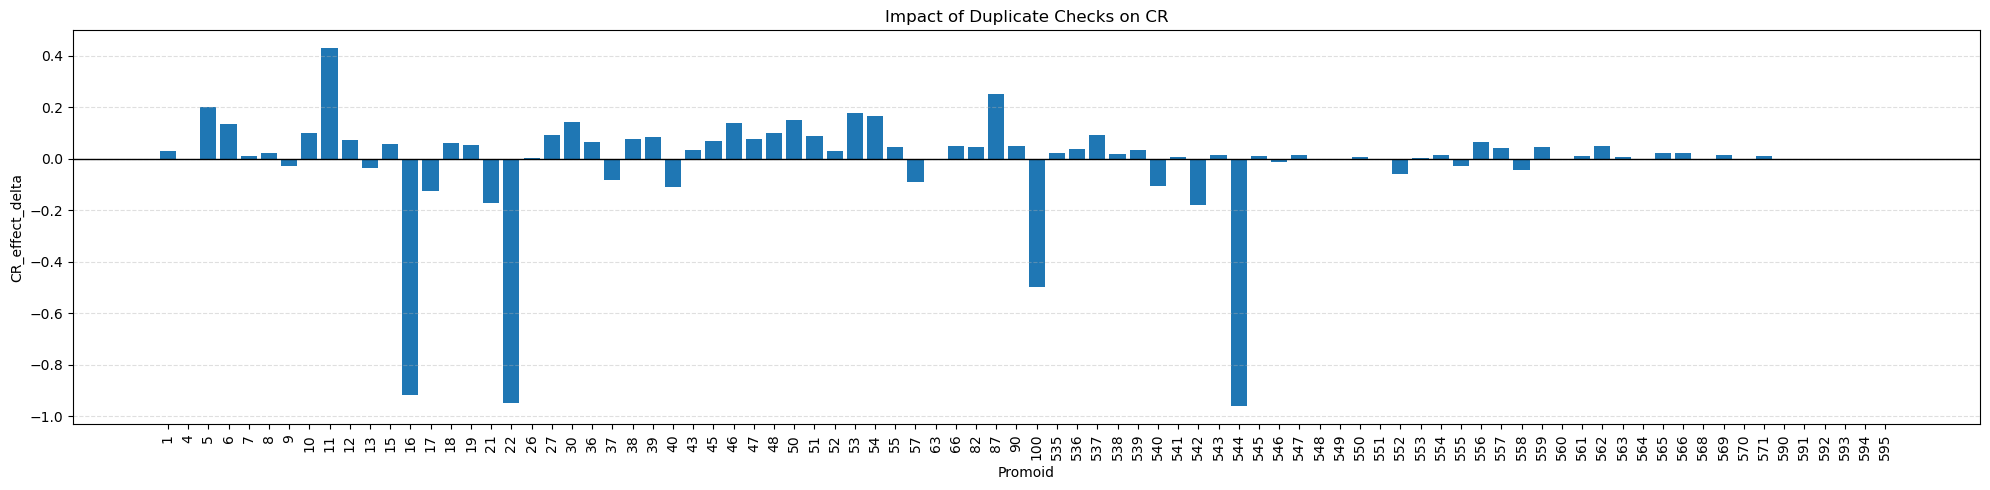

In [11]:
promos = df["promoid"].astype(str)

plt.figure(figsize=(20, 5))
plt.bar(promos, df["CR_effect_delta"])
plt.axhline(0, color="black", linewidth=1)
plt.title("Impact of Duplicate Checks on CR")
plt.xlabel("Promoid")
plt.ylabel("CR_effect_delta")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()


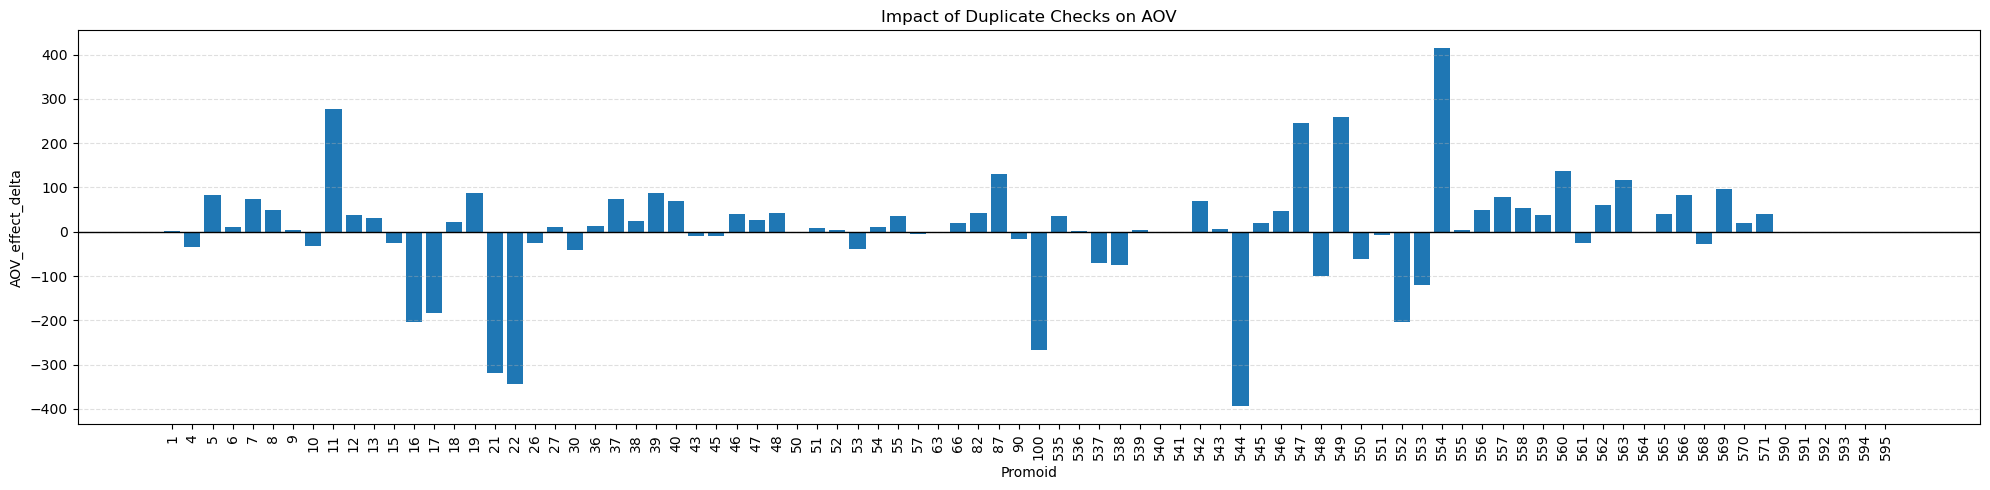

In [20]:
plt.figure(figsize=(20, 5))
plt.bar(promos, df["AOV_effect_delta"])
plt.axhline(0, color="black", linewidth=1)
plt.title("Impact of Duplicate Checks on AOV")
plt.xlabel("Promoid")
plt.ylabel("AOV_effect_delta")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

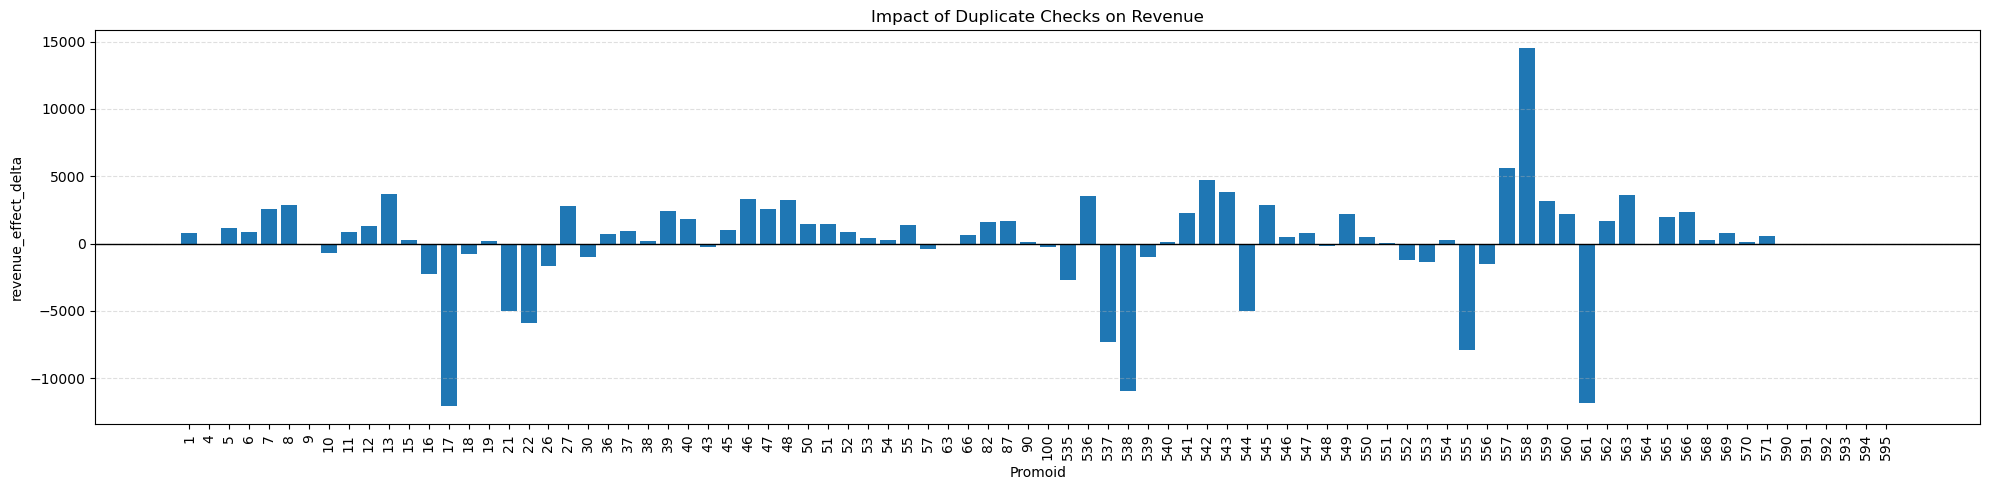

In [21]:
plt.figure(figsize=(20, 5))
plt.bar(promos, df["revenue_effect_delta"])
plt.axhline(0, color="black", linewidth=1)
plt.title("Impact of Duplicate Checks on Revenue")
plt.xlabel("Promoid")
plt.ylabel("revenue_effect_delta")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

Вплив таких дублікатів на показники суттєво варіюється між промо-кампаніями. <br>У більшості випадків викривлення невелике, проте є деяка кількість промо з дуже високою чутливістю до дублів.<br>
Promoid 16, 17, 22, 544 дельта CR змінюється майже на 1 пункт, значний вплив на AOV помітний навіть в більшої кількості промо.<br>
Це означає, що при оцінці ефективності таких промо використання задубльованих чеків може призвести до хибних висновків і неправильних бізнес-рішень.

При попередньому аналізі (у завданні 1) для промо 17 було виявлено статистично значуще зростання конверсії, однак середній чек демонстрував зниження.<br> Аналіз із урахуванням дублікатів показує, що саме вони суттєво впливають на AOV: графік показує, що дублікати занижують середній чек, тим самим викривлюючи оцінку реальної ефективності промо.<br>

In [12]:
df[["CR_effect_delta", "AOV_effect_delta", "revenue_effect_delta"]].abs().mean()

CR_effect_delta            0.093871
AOV_effect_delta          68.332977
revenue_effect_delta    2128.174999
dtype: float64

Дублікати чеків в середньому не мають значний вплив на конверсію, проте суттєво спотворюють фінансові показники: середній чек у середньому зміщується на 68 грн, а розрахунок додаткового доходу більш ніж на 2 тис. грн.<br>Це означає, що за наявності дублікатів промо-кампанії можуть виглядати значно ефективнішими, або навпаки менш прибутковими, ніж є насправді, що створює високий ризик прийняття некоректних рішень.

Для коректного розуміння впливу промо на конверсію, середній чек та інші показники бажано усунути дублювання чеків в різних Promoid.<br>
Потрібно розглянути можливість:<br>
- Виключати дублікати на етапі формування аналітичного датасету, так як ми не знаємо яка саме промо-кампанія спричинила конверсію <br>
- Визначати чітке правило прив’язки чека до одного промо, наприклад за останньою подією<br>
- При формуванні вибірки для A/B тесту розподіляти клієнтів тільки в одну промо-кампанію щоб уникнути перетинів та подвійного обліку<br>

In [8]:
df.to_excel("promo_results.xlsx", index=False, engine="openpyxl")